In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os

from matplotlib import pyplot


from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [23]:
# single household contsumption data extract function
def extract_house(data_frame, lclid):
    df = data_frame.set_index("tstp")
    df.index = df.index.astype("datetime64")
    df = df[df["energy(kWh/hh)"] != "Null"]
    df["energy(kWh/hh)"] = df["energy(kWh/hh)"].astype("float64")
    df = df[df["LCLid"] == "{}".format(lclid) ]
    return df

In [24]:
# weather extraction function
def extract_weather(data_frame):
    df = data_frame.set_index("time")
    df.index = df.index.astype("datetime64")
    return df

In [3]:
# convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('var{}(t-{})'.format(j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('var{}(t+{})'.format(j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

**Processing csv document into energy consumption per housedhold per hour during the recorded period**

In [83]:
df = pd.read_csv("smart-meters-in-london/halfhourly_dataset/block_0.csv")
for num in range(1,111):    
    df = df.append(pd.read_csv("smart-meters-in-london/halfhourly_dataset/block_"+str(num)+".csv"))
        


In [86]:
df = df[df["energy(kWh/hh)"] != "Null"]
df["energy(kWh/hh)"] = df["energy(kWh/hh)"].astype("float64")

In [89]:
df = df.groupby('tstp').sum()

In [93]:
df.index = df.index.astype("datetime64")

In [95]:
df = df.resample('1H').sum()

In [201]:
df['tstp'] = df.index
df.tstp = df.tstp.astype("datetime64")

In [203]:
df.head(10)

,energy(kWh/hh),av_kWh/hh,tstp
tstp,,,
2011-11-23 09:00:00,1.130,NaN,2011-11-23 09:00:00
2011-11-23 10:00:00,1.508,NaN,2011-11-23 10:00:00
2011-11-23 11:00:00,2.123,NaN,2011-11-23 11:00:00
2011-11-23 12:00:00,6.589,NaN,2011-11-23 12:00:00
2011-11-23 13:00:00,6.263,NaN,2011-11-23 13:00:00
2011-11-23 14:00:00,6.184,NaN,2011-11-23 14:00:00
2011-11-23 15:00:00,4.902,NaN,2011-11-23 15:00:00
2011-11-23 16:00:00,4.867,NaN,2011-11-23 16:00:00
2011-11-23 17:00:00,6.169,NaN,2011-11-23 17:00:00


In [133]:
df['av_kWh'] = df["energy(kWh/hh)"]/housecount['LCLid']

In [220]:
#read in housecount to get average eneregy consumption
housecount = pd.read_csv("housecount.csv")
housecount.head(10)
housecount.index = housecount.day

housecount.index = housecount.index.astype("datetime64")


In [130]:
housecount.day = housecount.day.astype("datetime64")
housecount.day.dtypes
housecount.LCLid = housecount.LCLid.astype("float64")

In [222]:
housecount = housecount.resample('1H').pad()

In [224]:
df = df.join(housecount)

In [226]:
df['av_kWh/hh'] = df['energy(kWh/hh)']/df['LCLid']

In [228]:
energy = df.drop(['tstp','day','LCLid','energy(kWh/hh)'],axis = 1)

**Load in weather hourly data**

In [16]:
weather = pd.read_csv('smart-meters-in-london/weather_hourly_darksky.csv')

In [102]:
weather = extract_weather(weather)

In [109]:
weather = weather.drop(['precipType'],axis = 1)
weather = weather.drop(['icon'],axis = 1)


KeyError: "['precipType'] not found in axis"

In [110]:
##encoding summary
weather.summary=weather.summary.astype('category').cat.codes

In [111]:
weather.head(10)

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,summary
time,,,,,,,,,
2011-11-11 00:00:00,5.97,104,10.24,8.86,1016.76,10.24,2.77,0.91,8
2011-11-11 01:00:00,4.88,99,9.76,8.83,1016.63,8.24,2.95,0.94,8
2011-11-11 02:00:00,3.70,98,9.46,8.79,1016.36,7.76,3.17,0.96,8
2011-11-11 03:00:00,3.12,99,9.23,8.63,1016.28,7.44,3.25,0.96,5
2011-11-11 04:00:00,1.85,111,9.26,9.21,1015.98,7.24,3.70,1.00,5
2011-11-11 05:00:00,1.96,115,9.33,8.87,1015.91,7.19,3.97,0.97,5
2011-11-11 06:00:00,1.30,118,9.31,8.82,1015.70,7.10,4.10,0.97,5
2011-11-11 07:00:00,1.22,114,8.85,8.69,1016.08,6.48,4.23,0.99,5
2011-11-11 08:00:00,1.40,120,9.13,8.75,1016.33,6.84,4.20,0.97,5


In [231]:
weather_energy = weather.merge(energy, left_index = True, right_index = True)

In [4]:
weather_energy = pd.read_csv("whh.csv")

In [50]:
weather_energy.head(100)

,Unnamed: 0,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,summary,av_kWh/hh
0,2011-12-11 00:00:00,12.50,210,2.83,1.17,1015.67,1.11,1.78,0.89,8,0.495915
1,2011-12-11 01:00:00,12.65,204,2.48,0.81,1014.96,0.31,2.11,0.89,4,0.443318
2,2011-12-11 02:00:00,13.02,214,2.70,1.29,1014.42,0.11,2.57,0.90,4,0.347353
3,2011-12-11 03:00:00,13.05,211,3.47,1.41,1013.78,0.66,3.00,0.86,8,0.315408
4,2011-12-11 04:00:00,12.97,204,3.74,1.53,1012.94,1.29,2.64,0.85,8,0.278582
5,2011-12-11 05:00:00,12.68,201,4.23,2.48,1012.42,1.82,2.70,0.88,6,0.297687
6,2011-12-11 06:00:00,12.54,199,5.16,3.01,1011.74,3.03,2.57,0.86,6,0.334428
7,2011-12-11 07:00:00,12.50,198,4.98,3.13,1011.26,2.39,3.12,0.88,8,0.335080
8,2011-12-11 08:00:00,12.01,190,5.79,3.73,1010.85,3.13,3.48,0.87,6,0.418856
9,2011-12-11 09:00:00,12.57,194,6.43,4.85,1010.44,3.72,3.79,0.90,8,0.551239


In [5]:
weather_energy.dropna(inplace=True)

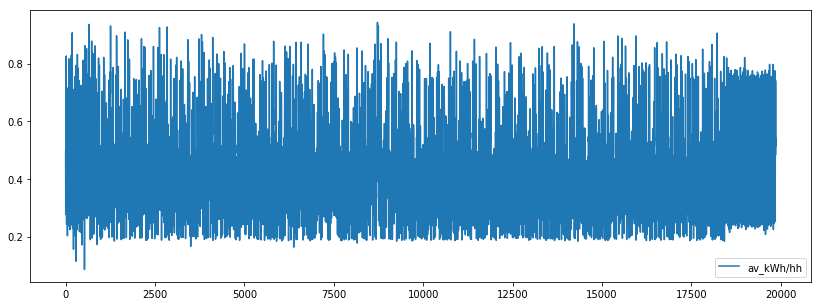

In [5]:
weather_energy.plot(y = 'av_kWh/hh', figsize = (14,5))

**Creat lag ahead scenarios**

In [6]:
#create 48 hours recency effect matrix
lag = lag_ahead_series(weather_energy.iloc[:,1:9], 48, 0, 8)


In [7]:
#create 48 housrs ahead energy consumption matrix
ahead = lag_ahead_series(weather_energy.iloc[:,10],0,49,True)

In [83]:
amatrix = ahead.values
lmatrix = lag.values
#weather_feature = weather_energy.iloc[:19803,1:].values
amatrix.shape, lmatrix.shape
#print(lmatrix.shape)

((19803, 49), (19803, 384))

In [84]:
##for manual regression algorithm
merge = np.concatenate((lmatrix[:19000,:], amatrix[:19000,:]),axis = 1)
scaler = MinMaxScaler(feature_range=(0, 1))
merge = scaler.fit_transform(merge)
X = merge[:,:384]
y = merge[:,384:]
X.shape, y.shape

((19000, 384), (19000, 49))

In [89]:
##preserve data for testing
merge = np.concatenate((lmatrix[19000:19803,:], amatrix[19000:19803,:]),axis = 1)
scaler = MinMaxScaler(feature_range=(0, 1))
merge = scaler.fit_transform(merge)
test_X = merge[:,:384]
test_y = merge[:,384:]
test_X.shape, test_y.shape

((803, 384), (803, 49))

In [34]:
##for TPOT 
X = lmatrix[:500,:]
y = amatrix[:500,:]
X.shape, y.shape

((500, 384), (500, 49))

In [35]:
X

array([[12.5 , 12.65, 13.02, ...,  0.8 ,  0.84,  0.86],
       [12.65, 13.02, 13.05, ...,  0.84,  0.86,  0.88],
       [13.02, 13.05, 12.97, ...,  0.86,  0.88,  0.93],
       ...,
       [13.6 , 13.68, 14.13, ...,  0.95,  0.95,  0.95],
       [13.68, 14.13, 14.13, ...,  0.95,  0.95,  0.95],
       [14.13, 14.13, 14.13, ...,  0.95,  0.95,  0.99]])

In [46]:
y


array([[0.49591542, 0.44331841, 0.34735323, ..., 0.59043651, 0.50308466,
        0.34317   ],
       [0.44331841, 0.34735323, 0.31540796, ..., 0.50308466, 0.34317   ,
        0.30447   ],
       [0.34735323, 0.31540796, 0.27858209, ..., 0.34317   , 0.30447   ,
        0.24158   ],
       ...,
       [0.69004233, 0.64587301, 0.61686508, ..., 0.47365616, 0.42481662,
        0.34089971],
       [0.64587301, 0.61686508, 0.60671693, ..., 0.42481662, 0.34089971,
        0.30293123],
       [0.61686508, 0.60671693, 0.5994127 , ..., 0.34089971, 0.30293123,
        0.26653868]])

In [11]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.9, test_size = 0.1,)

In [12]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((180, 384), (20, 384), (180, 49), (20, 49))

**TPOT**

In [11]:
from dic import mul_reg_config_dict


In [37]:
mul_reg_config_dict = {
    
    #regressors need not wrappers
    'sklearn.multioutput.MultiOutputRegressor': {
        'estimator': {
            'sklearn.svm.LinearSVR': {
                'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
                'dual': [True, False],
                'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
                'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
                'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.]
            }
  
        }
    },
    
    # Preprocesssors
    'sklearn.preprocessing.Binarizer': {
        'threshold': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.decomposition.FastICA': {
        'tol': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.cluster.FeatureAgglomeration': {
        'linkage': ['ward', 'complete', 'average'],
        'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
    },

    'sklearn.preprocessing.MaxAbsScaler': {
    },

    'sklearn.preprocessing.MinMaxScaler': {
    },

    'sklearn.preprocessing.Normalizer': {
        'norm': ['l1', 'l2', 'max']
    },

    'sklearn.kernel_approximation.Nystroem': {
        'kernel': ['rbf', 'cosine', 'chi2', 'laplacian', 'polynomial', 'poly', 'linear', 'additive_chi2', 'sigmoid'],
        'gamma': np.arange(0.0, 1.01, 0.05),
        'n_components': range(1, 11)
    },

    'sklearn.decomposition.PCA': {
        'svd_solver': ['randomized'],
        'iterated_power': range(1, 11)
    },

    'sklearn.preprocessing.PolynomialFeatures': {
        'degree': [2],
        'include_bias': [False],
        'interaction_only': [False]
    },

    'sklearn.kernel_approximation.RBFSampler': {
        'gamma': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.preprocessing.RobustScaler': {
    },

    'sklearn.preprocessing.StandardScaler': {
    },

    'tpot.builtins.ZeroCount': {
    },

    'tpot.builtins.OneHotEncoder': {
        'minimum_fraction': [0.05, 0.1, 0.15, 0.2, 0.25],
        'sparse': [False],
        'threshold': [10]
    },


    # Selectors
    'sklearn.feature_selection.SelectFwe': {
        'alpha': np.arange(0, 0.05, 0.001),
        'score_func': {
            'sklearn.feature_selection.f_regression': None
        }
    },

    'sklearn.feature_selection.SelectPercentile': {
        'percentile': range(1, 100),
        'score_func': {
            'sklearn.feature_selection.f_regression': None
        }
    },

    'sklearn.feature_selection.VarianceThreshold': {
        'threshold': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
    },

    'sklearn.feature_selection.SelectFromModel': {
        'threshold': np.arange(0, 1.01, 0.05),
        'estimator': {
            'sklearn.ensemble.ExtraTreesRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05)
            }
        }
    }

}


In [38]:
from tpot import TPOTRegressor
#import mul_config as mc## import multioutput regressor customized configuration

tpot_reg = TPOTRegressor(generations=3, population_size=30, n_jobs=-1, verbosity=3, random_state=12345, config_dict=mul_reg_config_dict)
tpot_reg.fit(X, y)
print(tpot_reg.score(test_X,test_y))

19 operators have been imported by TPOT.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.
Generation 1 - Current Pareto front scores:
-1	-0.026517519735910655	MultiOutputRegressor(input_matrix, MultiOutputRegressor__LinearSVR__C=0.001, MultiOutputRegressor__LinearSVR__dual=False, MultiOutputRegressor__LinearSVR__epsilon=0.01, MultiOutputRegressor__LinearSVR__loss=squared_epsilon_insensitive, MultiOutputRegressor__LinearSVR__tol=1e-05)

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insen

In [39]:
tpot_reg.export("400.py")

In [66]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVR

# NOTE: Make sure that the class is labeled 'target' in the data file

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=12345)

# Average CV score on the training set was:-0.01896679778971667
exported_pipeline = make_pipeline(
    MinMaxScaler(),
    MultiOutputRegressor(estimator=LinearSVR(C=0.01, dual=False, epsilon=0.1, loss="squared_epsilon_insensitive", tol=1e-05))
)

exported_pipeline.fit(train_X, train_y)
results = exported_pipeline.predict(val_X)


In [67]:
results.shape, test_y.shape

((125, 49), (125, 49))

**Result evaluation**

In [69]:
import math
rmse = math.sqrt(mean_squared_error(val_y, results))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.124


In [81]:
real = np.transpose(val_y)
guess = np.transpose(results)

real.shape, guess.shape

real = real[:1,:49]
guess = guess[:5,:49]

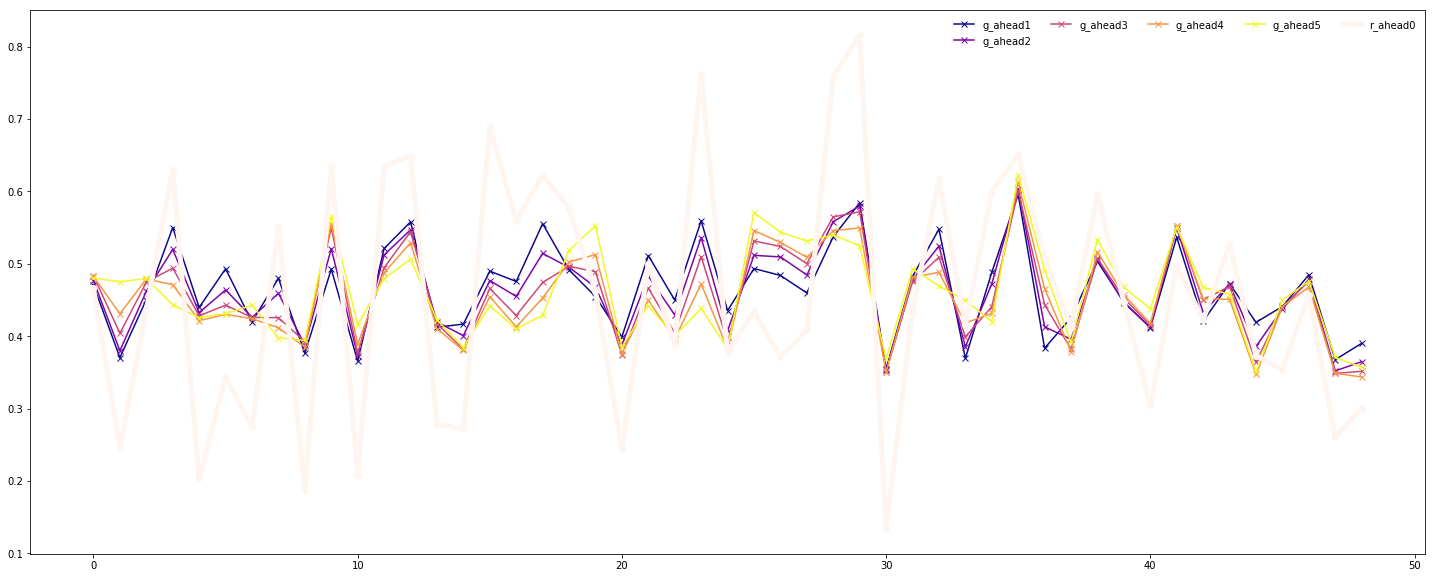

In [82]:
from matplotlib import cm
import matplotlib.pyplot as plt
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

i = 0
for row in real:
    rpdf.insert(i, "r_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "g_ahead{}".format(i+1), row, True) 
    i += 1
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='-x',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), colormap = 'Reds',style ='-o',legend = True, ax = ax, lw =5)
ax.legend(frameon=False, loc='upper right', ncol=5)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()



**random forest regression**

In [140]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
rfr.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [169]:
#extact predicted values but reverse normalization first
yhat = rfr.predict(test_X)
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:1,384:]
#extract exact values but reverse normalization first
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:49,384:385]



In [170]:
inv_yhat.shape, inv_y.shape

((1, 49), (49, 1))

**Result evaluation**

In [171]:
#mean square error between exact and predict values
import math
rmse = math.sqrt(mean_squared_error(inv_y.transpose(), inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.100


In [172]:
#data preprocess
real = inv_y.transpose()
guess = inv_yhat

real.shape, guess.shape

#real = real[:1,:49]
#guess = guess[:5,:49]

((1, 49), (1, 49))

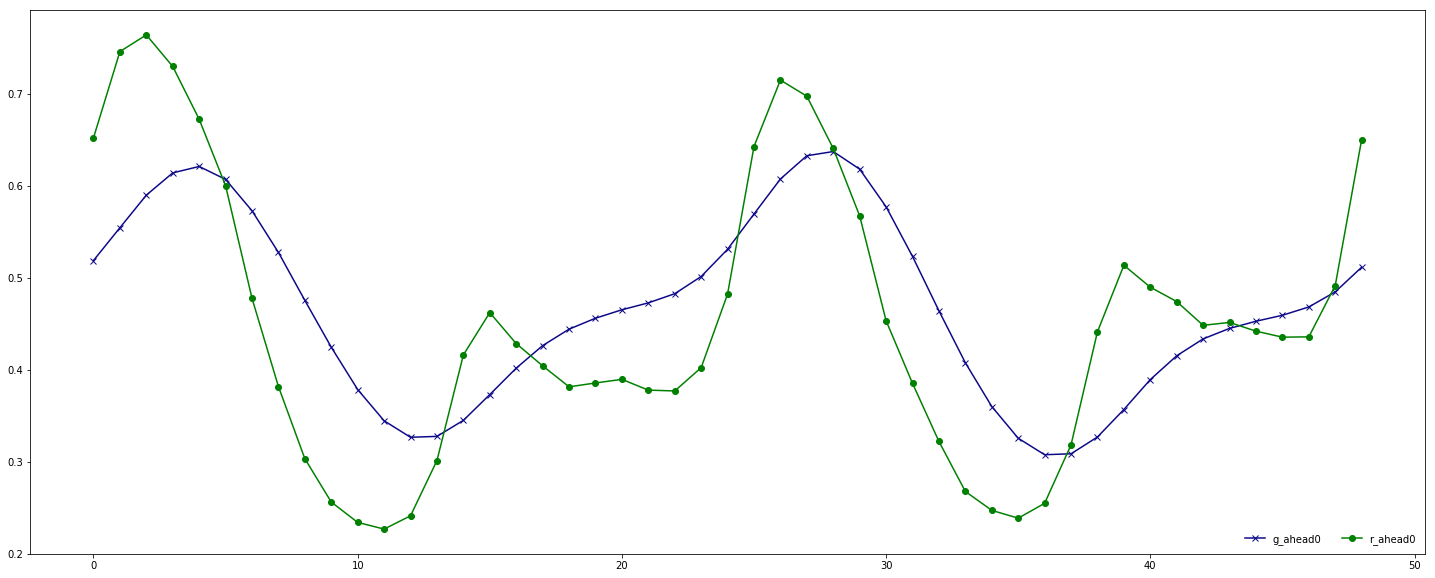

In [173]:
from matplotlib import cm
import matplotlib.pyplot as plt
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

i = 0
for row in real:
    rpdf.insert(i, "r_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "g_ahead{}".format(i), row, True) 
    i += 1
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='-x',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()

**LSTM**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             87000     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 49)             2499      
Total params: 89,499
Trainable params: 89,499
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 1s - loss: 0.1434
Epoch 2/50
 - 1s - loss: 0.1028
Epoch 3/50
 - 1s - loss: 0.0937
Epoch 4/50
 - 1s - loss: 0.0876
Epoch 5/50
 - 1s - loss: 0.0842
Epoch 6/50
 - 1s - loss: 0.0821
Epoch 7/50
 - 1s - loss: 0.0806
Epoch 8/50
 - 1s - loss: 0.0793
Epoch 9/50
 - 1s - loss: 0.0783
Epoch 10/50
 - 1s - loss: 0.0772
Epoch 11/50
 - 1s - loss: 0.0764
Epoch 12/50
 - 1s - loss: 0.0755
Epoch 13/50
 - 1s - loss: 0.0747
Epoch 14/50
 - 1s - loss: 0.0740
Epoch 15/50
 - 1s - loss: 0.0733
Epoch 16/50
 - 1s - loss: 

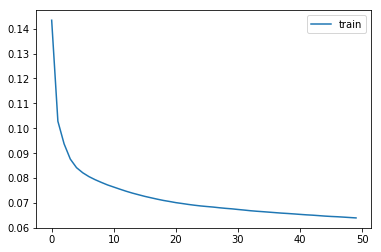

In [86]:
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.9, test_size = 0.1)
ltrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
lval_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
ltrain_y = train_y.reshape((train_y.shape[0],1, train_y.shape[1]))

from keras.layers import TimeDistributed
# design network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(ltrain_X.shape[1], ltrain_X.shape[2]),return_sequences = True))
model.add(TimeDistributed(Dense(49)))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(ltrain_X, ltrain_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [93]:
test_X.shape

(803, 1, 384)

In [92]:

test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

#ltrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#lval_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
#ltrain_y = train_y.reshape((train_y.shape[0],1, train_y.shape[1]))


In [97]:
ptest_X.shape, test_y.shape

((803, 384), (803, 49))

In [95]:
yhat = model.predict(test_X)
yhat = yhat.reshape(yhat.shape[0],yhat.shape[2])
ptest_X = test_X.reshape(test_X.shape[0], test_X.shape[2])
# invert scaling for "predict"
inv_yhat = np.concatenate((ptest_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)



In [98]:
# invert scaling for "actual"
#ltest_y = test_y.reshape((len(test_y), 8))
inv_y = np.concatenate((ptest_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_yhat = inv_yhat[:,384:]
inv_y = inv_y[:,384:]

In [99]:
inv_y.shape, inv_yhat.shape


((803, 49), (803, 49))

**performace**

import math
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [112]:
#data preprocess
real = np.transpose(inv_y)
guess = np.transpose(inv_yhat)

real = real[:1,:200]
guess = guess[:5,:200]

In [113]:
real.shape, guess.shape

((1, 200), (5, 200))

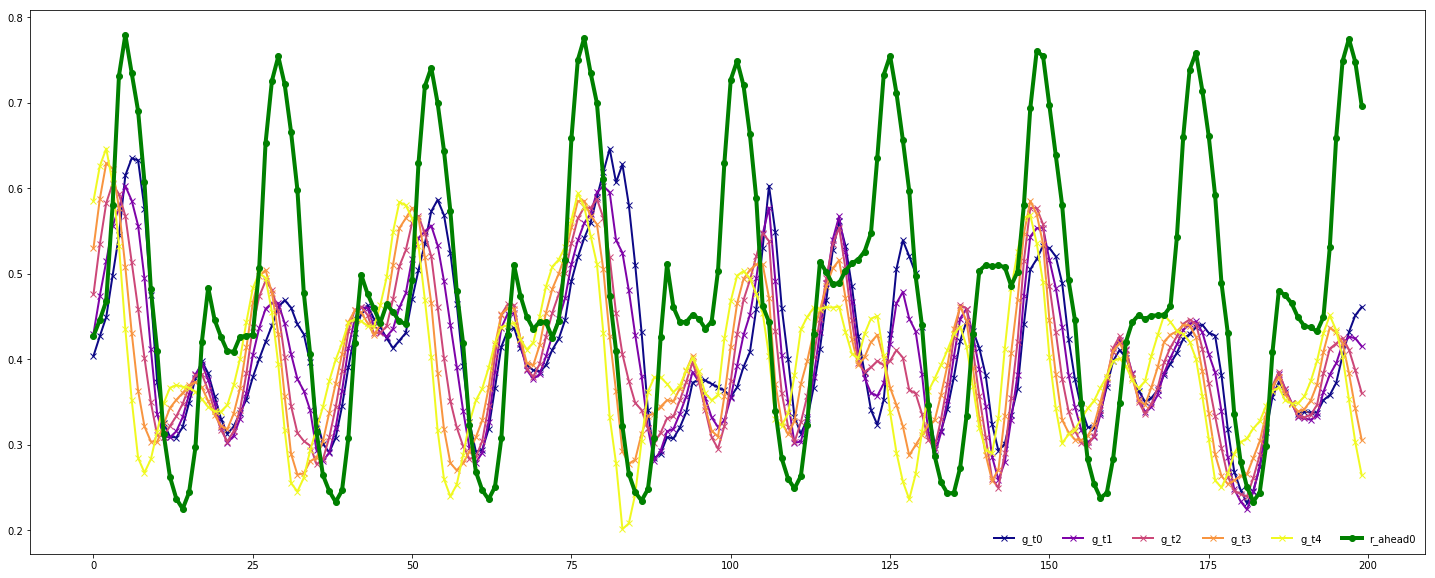

In [114]:
from matplotlib import cm
import matplotlib.pyplot as plt
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

ax = plt.gca()
i = 0
for row in real:
    rpdf.insert(i, "r_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "g_t{}".format(i), row, True) 
    
    i += 1
    
#plot 
gpdf.plot(figsize=(25,10),colormap='plasma',style='-x',legend = True, ax = ax, lw = 2)
rpdf.plot(figsize=(25,10), color='Green',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()

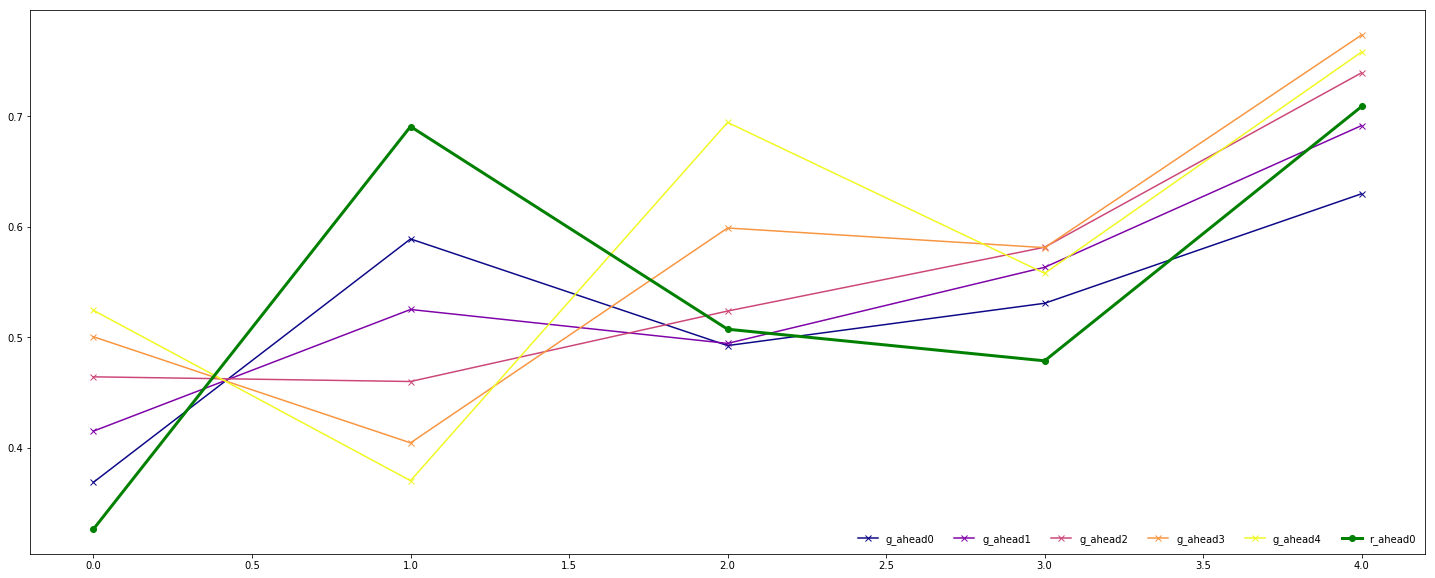

In [54]:
from matplotlib import cm
import matplotlib.pyplot as plt
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

i = 0
for row in real:
    rpdf.insert(i, "r_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "g_ahead{}".format(i), row, True) 
    i += 1
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10),colormap='plasma',style='-x',legend = True, ax = ax)
rpdf['r_ahead0'].plot(figsize=(25,10), color='Green',style ='-o',legend = True, ax = ax, lw = 3)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()

**XGBoost**

In [75]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
xreg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
mreg = MultiOutputRegressor(xreg)
mreg.fit(train_X, train_y)


//miniconda3/envs/TPOT2/lib/python3.5/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


MultiOutputRegressor(estimator=XGBRegressor(alpha=10, base_score=0.5,
                                            booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.3, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=5, min_child_weight=1,
                                            missing=None, n_estimators=10,
                                            n_jobs=1, nthread=None,
                                            objective='reg:squarederror',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, su

In [76]:
#extact predicted values but reverse normalization first
yhat = mreg.predict(test_X)
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,384:]
#extract exact values but reverse normalization first
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,384:]



**Performance**


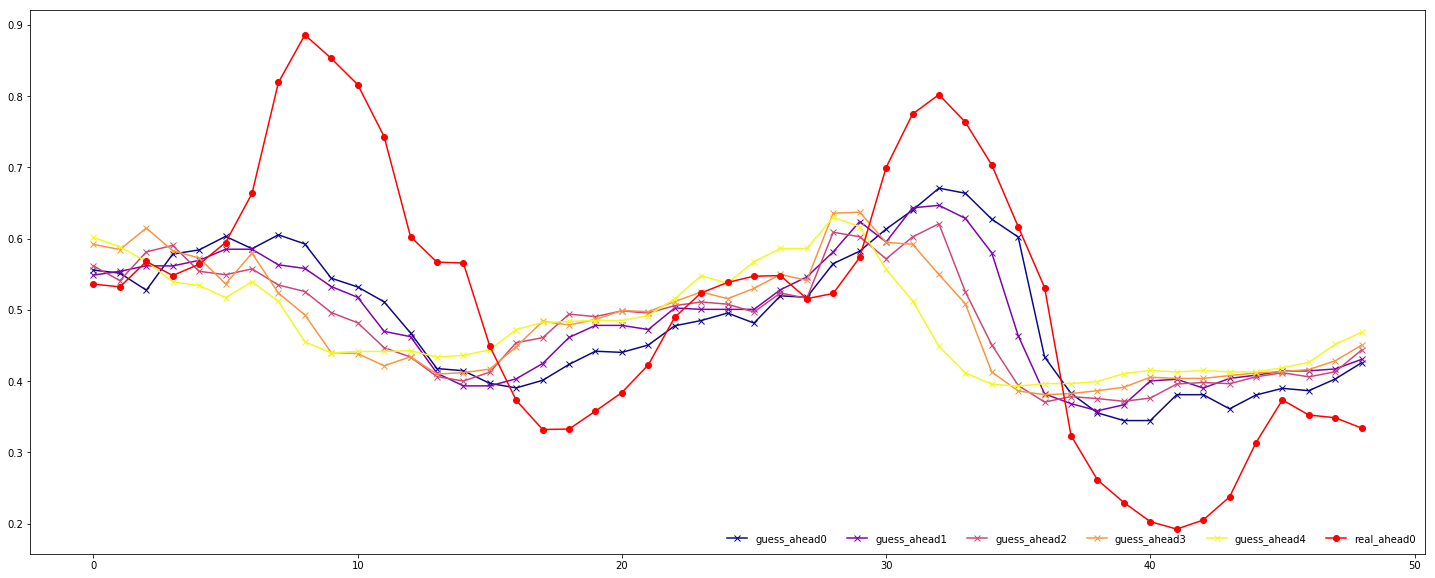

In [100]:
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

i = 0
for row in real:
    rpdf.insert(i, "real_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "guess_ahead{}".format(i), row, True) 
    i += 1
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='-x',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'Red',style ='-o',legend = True, ax = ax)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()

In [83]:
#data preprocess
real = np.transpose(inv_y)
guess = np.transpose(inv_yhat)

real.shape, guess.shape

#real = real[:1,:49]
#guess = guess[:5,:49]

((49, 1000), (49, 1000))

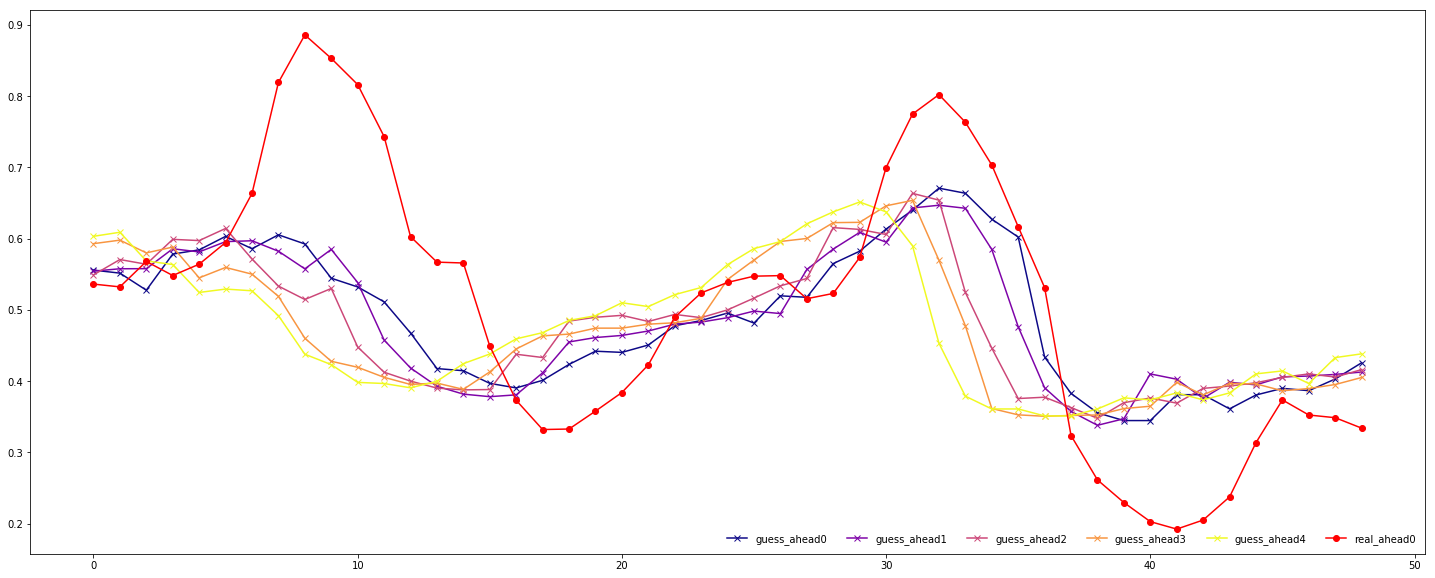

In [78]:
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

i = 0
for row in real:
    rpdf.insert(i, "real_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "guess_ahead{}".format(i), row, True) 
    i += 1
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='-x',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'Red',style ='-o',legend = True, ax = ax)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()

In [97]:
import xgboost as xgb
from sklearn.multioutput import RegressorChain
xreg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
mreg = RegressorChain(xreg)
mreg.fit(train_X, train_y)


//miniconda3/envs/TPOT2/lib/python3.5/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


RegressorChain(base_estimator=XGBRegressor(alpha=10, base_score=0.5,
                                           booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.3, gamma=0,
                                           importance_type='gain',
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=5, min_child_weight=1,
                                           missing=None, n_estimators=10,
                                           n_jobs=1, nthread=None,
                                           objective='reg:squarederror',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
   

In [98]:
#extact predicted values but reverse normalization first
yhat = mreg.predict(test_X)
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,384:]
#extract exact values but reverse normalization first
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,384:]



In [99]:
#data preprocess
real = np.transpose(inv_y)
guess = np.transpose(inv_yhat)

real.shape, guess.shape

real = real[:1,:49]
guess = guess[:5,:49]